#### 5. Modeling 

Mit der Data Preparation ist die Datenverarbeitung weitestgehend abgeschlossen. Allerdings bedarf es in Abhängigkeit von der Methode, weitere modellspezifische Datenvorbereitung. Die einzelnen Schritte werden an der jeweiligen Stelle vor dem Training kurz beschrieben.
Die folgenden Modelle bieten sich für die vorliegende Klassifikationsaufgabe an und werden im Verlauf dieses Schrittes zunächst gerechnet, dann angepasst (u.a. mittels Parametertuning und Cross-Validation) sowie bewertet:  

    1) Decision Tree & Random Forest  
    2) xgBoost  
    3) Suport Vector Machine  

Die hierfür benötigten Pakete stammen aus der bereits aufgeführten Scikit-Learn Bibliothek (abgekürzt sklearn) und umfassen im Wesentlichen: 

*train_test_split*: Zur Überprüfung der Effektivität eines Machine-Learning-Modells wird der ursprüngliche Datensatz in ein Trainingsset und ein Testset aufgeteilt. Das Trainingsset dient dazu, das Modell mit einem Teil der Daten zu trainieren. Anschließend wird das Testset verwendet, um die Leistung des Modells auf einem separaten Teil der Daten zu evaluieren (Pedregosa et al. 2011). 

*accuracy_score*: Dient als Bewertungsmaß für die Leistung eines Klassifikationsmodells indem es den Anteil der korrekt vorhergesagter Werte ermittelt und diese mit den tatsächlichen Labels vergleicht (Pedregosa et al. 2011).

*classification_report*: Erzeugt einen Bericht über die Leistung des Klassifikationsmodells und enthält Precision (Anzahl der positiv klassifizierten Instanzen, die tatsächlich positiv sind), Recall (wie gut erkennt das Modell positive Instanzen) und F1-Score (harmonischer Mittelwert von Recall und Precision) (Pedregosa et al. 2011).

*confusion_matrix*: erstellt eine vier Felder Matrix und vergleicht die tatsächlichen und vorhergesagten Klassifikationen:

|               | Vorhergesagt Positiv      | Vorhergesagt Negativ     |
|---------------|--------------|-------------|
| Tatsächlich Positiv       |   TP         |   FN        |
| Tatsächlich Negativ       |   FP         |   TN        |

- *True Positives (TP)*: Die Anzahl der tatsächlichen positiven Fälle, die korrekt als positiv vorhergesagt wurden.
- *False Positives (FP)*: Die Anzahl der tatsächlichen negativen Fälle, die fälschlicherweise als positiv vorhergesagt wurden.
- *True Negatives (TN)*: Die Anzahl der tatsächlichen negativen Fälle, die korrekt als negativ vorhergesagt wurden.
- *False Negatives (FN)*: Die Anzahl der tatsächlichen positiven Fälle, die fälschlicherweise als negativ vorhergesagt wurden.  

*DecisionTreeClassifier / RandomForestClassifier*: Sie dienen dazu, Entscheidungsbaum-Modelle für Klassifikationsaufgaben zu erstellen und zu trainieren (Pedregosa et al. 2011).

*GridSearchCV / RandomizedSearchCV*: Sie werden zur Hyperparameter-Optimierung verwendet, indem sie systematisch verschiedene Kombinationen (innerhalb eines vordefinierten Rasters) von Hyperparametern testen und bewerten (Pedregosa et al. 2011).

*plot_tree*: Zur grafischen Darstellung von Entscheidungsbäumen (Pedregosa et al. 2011).


In [47]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, precision_recall_curve, roc_curve, precision_score, recall_score, f1_score,  mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import shap

import math

import xgboost as xgb
from xgboost import XGBClassifier
import sys

from scipy.stats import uniform, randint

Zunächst werden die Daten als "pickle" eingelesen.

In [50]:
# Der Datensatz employee_data_transformed enthält den Datentyp "object", im Datensatz employee_data wurde der Datentyp "object" mittels One-Hot Encoding in Booleans umgewandelt

employee_data_transformed = pd.read_pickle('../HR_Data_raw.pkl')
employee_data = pd.read_pickle('../HR_Data_One_Hot_Encoded.pkl')

Überprüfen ob die Spalten und Daten wie erwartet bereinigt sind. 

In [51]:
employee_data.tail()

Attrition  Age  DistanceFromHome  Education  EmployeeNumber  \
1465        No   36                23          2            2061   
1466        No   39                 6          1            2062   
1467        No   27                 4          3            2064   
1468        No   49                 2          3            2065   
1469        No   34                 8          3            2068   

      EnvironmentSatisfaction  Gender  JobInvolvement  JobLevel  \
1465                        3       0               4         2   
1466                        4       0               2         3   
1467                        2       0               4         2   
1468                        4       0               2         2   
1469                        2       0               4         2   

      JobSatisfaction  ...  JobRole_Laboratory Technician  JobRole_Manager  \
1465                4  ...                           True            False   
1466                1  ...                          False            False   
1467                2  ...                          False            False   
1468                2  ...                          False            False   
1469                3  ...                           True            False   

      JobRole_Manufacturing Director  JobRole_Research Director  \
1465                           False                      False   
1466                           False                      False   
1467                            True                      False   
1468                           False                      False   
1469                           False                      False   

      JobRole_Research Scientist  JobRole_Sales Executive  \
1465                       False                    False   
1466                       False                    False   
1467                       False                    False   
1468                       False                     True   
1469                       False                    False   

      JobRole_Sales Representative  MaritalStatus_Divorced  \
1465                         False                   False   
1466                         False                   False   
1467                         False                   False   
1468                         False                   False   
1469                         False                   False   

      MaritalStatus_Married  MaritalStatus_Single  
1465                   True                 False  
1466                   True                 False  
1467                   True                 False  
1468                   True                 False  
1469                   True                 False  

[5 rows x 45 columns]

##### *5.1 Vorbereitung: Test-Train-Split, SMOTE & Feature Importance*

Zunächst werden die Eingabevariablen bzw. Features im X-Array und die vorherzusagenden Labels, also die Zielvariable ("Attrition"), im Y-Array für alle Modelle einmalig zu Beginn definiert. Beim Split in Test- und Trainingsdaten im Verhältnis 25 zu 75 wird der *random_state* auf 42 gesetzt (als Anspielung auf *die ultimative Antwort auf die Frage nach dem Leben, dem Universum und allem*, basierend auf "Per Anhalter durch die Galaxis" von Douglas Adams). Der *random_state* sorgt für die Reproduzierbarkeit der Ergebnisse. Um das Problem der Datenungleichheit im Trainingsset innerhalb der Zielvariable (Yes: 237 vs. No: 1233) zu begegnen, wird SMOTE (Synthetic Minority Over-sampling Technique) angewandt. SMOTE generiert neue synthetische Beispiele für die Minderheitsklasse durch Interpolation zwischen bestehenden Instanzen im Merkmalsraum (Wang et al. 2006). Nach Anwendung dieses Verfahrens befinden sich in der Zielvariable des Trainingsdatensatz jeweils 913 Werte beider Klassen.

In [65]:
#Aufteilen der Daten in Zielvariable X und Attribute Y.
X = employee_data.drop('Attrition', axis=1)
y = employee_data.Attrition

In [66]:
# Erstellen eines LabelEncoders
label_encoder = LabelEncoder()

# Konvertieren von 'No'/'Yes' in 0/1
y_enc = label_encoder.fit_transform(y)

#Aufteilen der Daten in Test und Trainingsdaten.
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.25, random_state=42)

In [67]:
# Anwendung von SMOTE auf die Trainingsdaten
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Überprüfen der neuen Klassenverteilung
print("Ursprüngliche Klassenverteilung:\n", y.value_counts())
print("Neue Klassenverteilung:\n", pd.Series(y_resampled).value_counts())

Ursprüngliche Klassenverteilung:
 Attrition
No     1233
Yes     237
Name: count, dtype: int64
Neue Klassenverteilung:
 0    913
1    913
Name: count, dtype: int64


Um die Leistung der Klassifikationsmodelle auf die Trainings- und Testdaten zu evaluieren und für alle Modelle gleich zu bewerten, wird die Ausgabe der bereits geschilderten Bewertungsmetriken innerhalb der Funktion *evaluation* definiert. 

In [68]:
# Funktion zum Evaluieren der verschiedenen Modelle
def evaluation(clf, X_resampled, y_resampled, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_resampled)
        clf_report = pd.DataFrame(classification_report(y_resampled, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_resampled, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_resampled, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

Vor der Anwendung des Decision Trees auf den vorbereiteten Datensatz, soll anhand des ursprünglichen Rohdatensatzes und der Feature Importance eines Entscheidungsbaums noch einmal überprüft werden, ob die im Data Preparation entfernten Variablen auch tatsächlich irrelevant sind. Die drei Variablen „StandardHours“, „EmployeeCount“ und „Over18“ tragen mit einer relativen Importance von 0.00 nicht zum Modell bei. Die beiden Einkommensvariablen „MonthlyRate“ und „HourlyRate“ weisen zwar eine relativ hohe Bedeutung für das Modell auf, stehen aber hinter dem „MonthlyIncome“ (auf Platz 2 mit einer relativen Importance von 0.09) und werden aufgrund der sehr hohen gemeinsamen Varianz und mangels Sinnhaftigkeit weiterhin ausgeschlossen.

In [70]:
employee_data_raw = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv', sep=',')
employee_data_raw.columns = employee_data_raw.columns.str.strip()

# Datenvorbereitung
categorical_col = []
for column in employee_data_raw.columns:
    if employee_data_raw[column].dtype == object:
        categorical_col.append(column)
for column in categorical_col:
    employee_data_raw[column] = employee_data_raw[column].astype("category").cat.codes
employee_data_raw['Attrition'] = employee_data_raw['Attrition'].astype("category").cat.codes

# Datenaufteilung
Xraw = employee_data_raw.drop('Attrition', axis=1).values  # Merkmale als NumPy-Array
yraw = employee_data_raw['Attrition'].values               # Zielvariable als NumPy-Array
Xraw_train, Xraw_test, yraw_train, yraw_test = train_test_split(Xraw, yraw, test_size=0.25, random_state=42)

# Anwendung von SMOTE auf die Trainingsdaten
smote = SMOTE(random_state=42)
X_raw_resampled, y_raw_resampled = smote.fit_resample(Xraw_train, yraw_train)

# Zählen der Anzahl der "Yes"-Labels (Attrition = 1) vor SMOTE
num_yes_before = np.sum(y_train == 1)
print(f"Anzahl der 'Yes' (Attrition = 1) vor SMOTE: {num_yes_before}")
num_yes_after = np.sum(y_raw_resampled == 1)
print(f"Anzahl der 'Yes' (Attrition = 1) nach SMOTE: {num_yes_after}")
#Entscheidungsbaum
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_raw_resampled, y_raw_resampled)

# Feature Wichtigkeit Roh-Daten ausgeben
feature_importances = tree_clf.feature_importances_
feature_names = employee_data_raw.drop('Attrition', axis=1).columns
feature_importance_employee_data_raw = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n", feature_importance_employee_data_raw)

Anzahl der 'Yes' (Attrition = 1) vor SMOTE: 189
Anzahl der 'Yes' (Attrition = 1) nach SMOTE: 913

Feature Importances:
                      Feature  Importance
26          StockOptionLevel    0.158817
17             MonthlyIncome    0.090098
13                  JobLevel    0.057727
31        YearsInCurrentRole    0.051581
18               MonthlyRate    0.047080
11                HourlyRate    0.046897
9    EnvironmentSatisfaction    0.045505
15           JobSatisfaction    0.042619
8             EmployeeNumber    0.039847
0                        Age    0.036320
29           WorkLifeBalance    0.036159
12            JobInvolvement    0.034316
2                  DailyRate    0.026369
33      YearsWithCurrManager    0.026256
32   YearsSinceLastPromotion    0.023352
14                   JobRole    0.022900
28     TrainingTimesLastYear    0.021599
16             MaritalStatus    0.019775
19        NumCompaniesWorked    0.019002
5                  Education    0.018847
30            Years

##### *5.2 Decision Tree (Entscheidungsbaum)*

Ohne jegliche Modelloptimierung erreicht der Decision Tree eine Genauigkeit von 100% auf den Trainingsdaten und auf die Testdaten bereits einen Accuracy Score von 79.699%. Die meisten (90.70%) als Klasse 0 (keine Fluktuation) vorhergesagten Instanzen sind korrekt. Allerdings sind nur 28.00% der als Fluktuation vorhergesagten Labels richtig. Außerdem werden weniger als die Hälfte der tatsächlichen Instanzen dieser Klasse korrekt klassifiziert. Dementsprechend fällt auch die Konfusionsmatrix aus: 266 Instanzen korrekt als Klasse 0, aber 54 fälschlicherweise als Klasse 1 vorhergesagt. 27 Labels als Klasse 1 vorhergesagt, obwohl sie eigentlich der Klasse 0 angehören. Demgegenüber stehen 21 Instanzen, die korrekt als Fluktuation klassifiziert wurden.

Die perfekte Leistung von 100% auf die Trainingsdaten kann ein Anzeichen von Overfitting sein und daher nicht gut auf unbekannte Daten generalisieren kann. Auf die Testdaten erzielt das Modell zwar insgesamt eine ordentliche Genauigkeit, aber die Leistung für das Label „Fluktuation“ ist suboptimal. Das Modell ist also nicht gut darin, die Minderheitsklasse zu erkennen. Möglicherweise kann ein anderes Modell hier bessere Werte erzielen.

In [71]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_resampled, y_resampled)

evaluation(tree_clf, X_resampled,  y_resampled, X_test, y_test, train=True)
evaluation(tree_clf, X_resampled,  y_resampled, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    913.0  913.0       1.0     1826.0        1826.0
_______________________________________________
Confusion Matrix: 
 [[913   0]
 [  0 913]]

Test Result:
Accuracy Score: 77.99%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.907850   0.280000  0.779891    0.593925      0.825956
recall       0.831250   0.437500  0.779891    0.634375      0.779891
f1-score     0.867863   0.341463  0.779891    0.604663      0.799202
support    320.000000  48.000000  0.779891  368.000000    368.000000
_______________________________________________
Conf

Die Variable „YearsInCurrentRole“ (Jahre in der aktuellen Position) hat die höchste relative Bedeutung (0.13) im Modell. Dies könnte dadurch erklärbar sein, dass dann die Hürden höher sind, das Unternehmen zu verlassen und andersherum. Auch das JobInvolvement (0.08), also Arbeitsengagement sowie das monatliche Einkommen (0.07) wirken sich -wenn auch geringer- auf die Klassifikation aus, was auch die Ergebnisse aus der Literaturrecherche sowie dem Data Understanding wiederspiegelt. Weitere wichtige Features mit einer mittleren relativen Wichtigkeit sind verheiratet (0.06) oder geschieden (0.05) sowie die beiden Zufriedenheitsskalen „EnvironmentSatisfacation“ (0.07) und JobSatisfaction (0.05). 

In [72]:
# Feature Wichtigkeit bereinigte Daten ausgeben
feature_importances = tree_clf.feature_importances_
feature_names = employee_data.drop('Attrition', axis=1).columns
feature_importance_employee_data = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n", feature_importance_employee_data)


Feature Importances:
                               Feature  Importance
17                 YearsInCurrentRole    0.130527
6                      JobInvolvement    0.075077
9                       MonthlyIncome    0.074525
4             EnvironmentSatisfaction    0.073155
42              MaritalStatus_Married    0.056643
41             MaritalStatus_Divorced    0.054278
8                     JobSatisfaction    0.046614
0                                 Age    0.045175
3                      EmployeeNumber    0.042884
10                 NumCompaniesWorked    0.039690
25                   Department_Sales    0.035532
11                           OverTime    0.031410
23         Department_Human Resources    0.026360
27       EducationField_Life Sciences    0.025323
29             EducationField_Medical    0.024993
24  Department_Research & Development    0.023716
1                    DistanceFromHome    0.022736
18            YearsSinceLastPromotion    0.021840
19               YearsWithC

In einem Entscheidungsbaum sind die wichtigsten Features tendenziell in den höheren Knoten des Baumes platziert. Je näher ein Feature an der Wurzel des Baumes erscheint und je öfter es verwendet wird, desto wichtiger ist es für die Entscheidungsfindung des Modells. Dies zeigt sich auch in der Grafik.

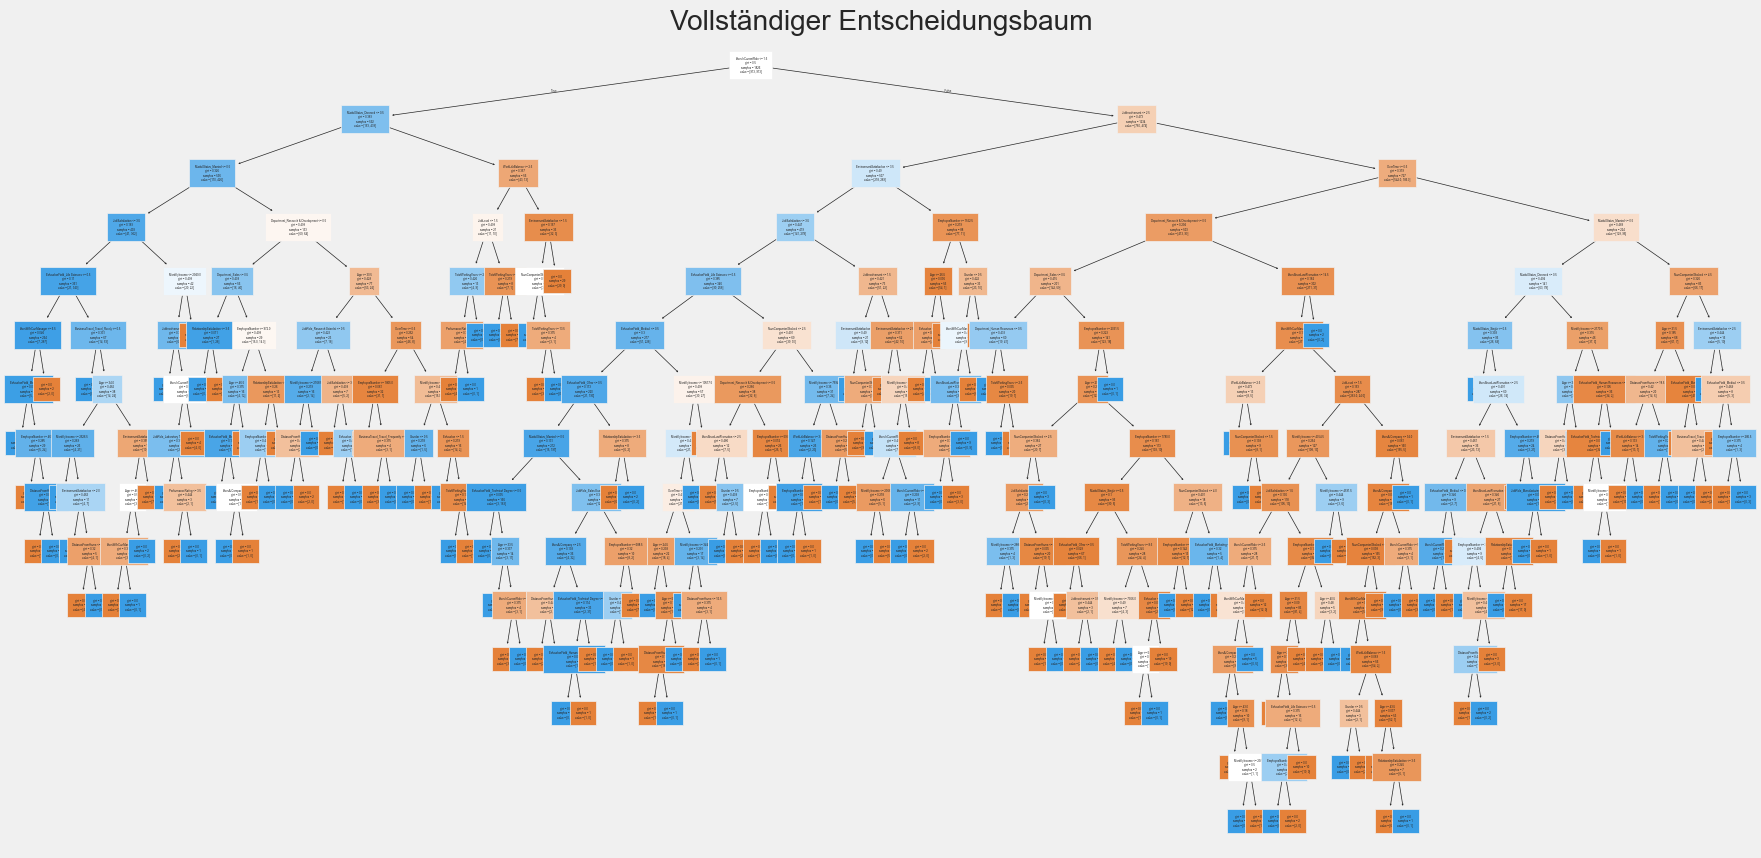

In [73]:
#Entscheidungsbaum visualisieren
plt.figure(figsize=(20, 10))
plot_tree(tree_clf, feature_names=feature_names, filled=True, fontsize=2)
plt.title("Vollständiger Entscheidungsbaum")
plt.show()

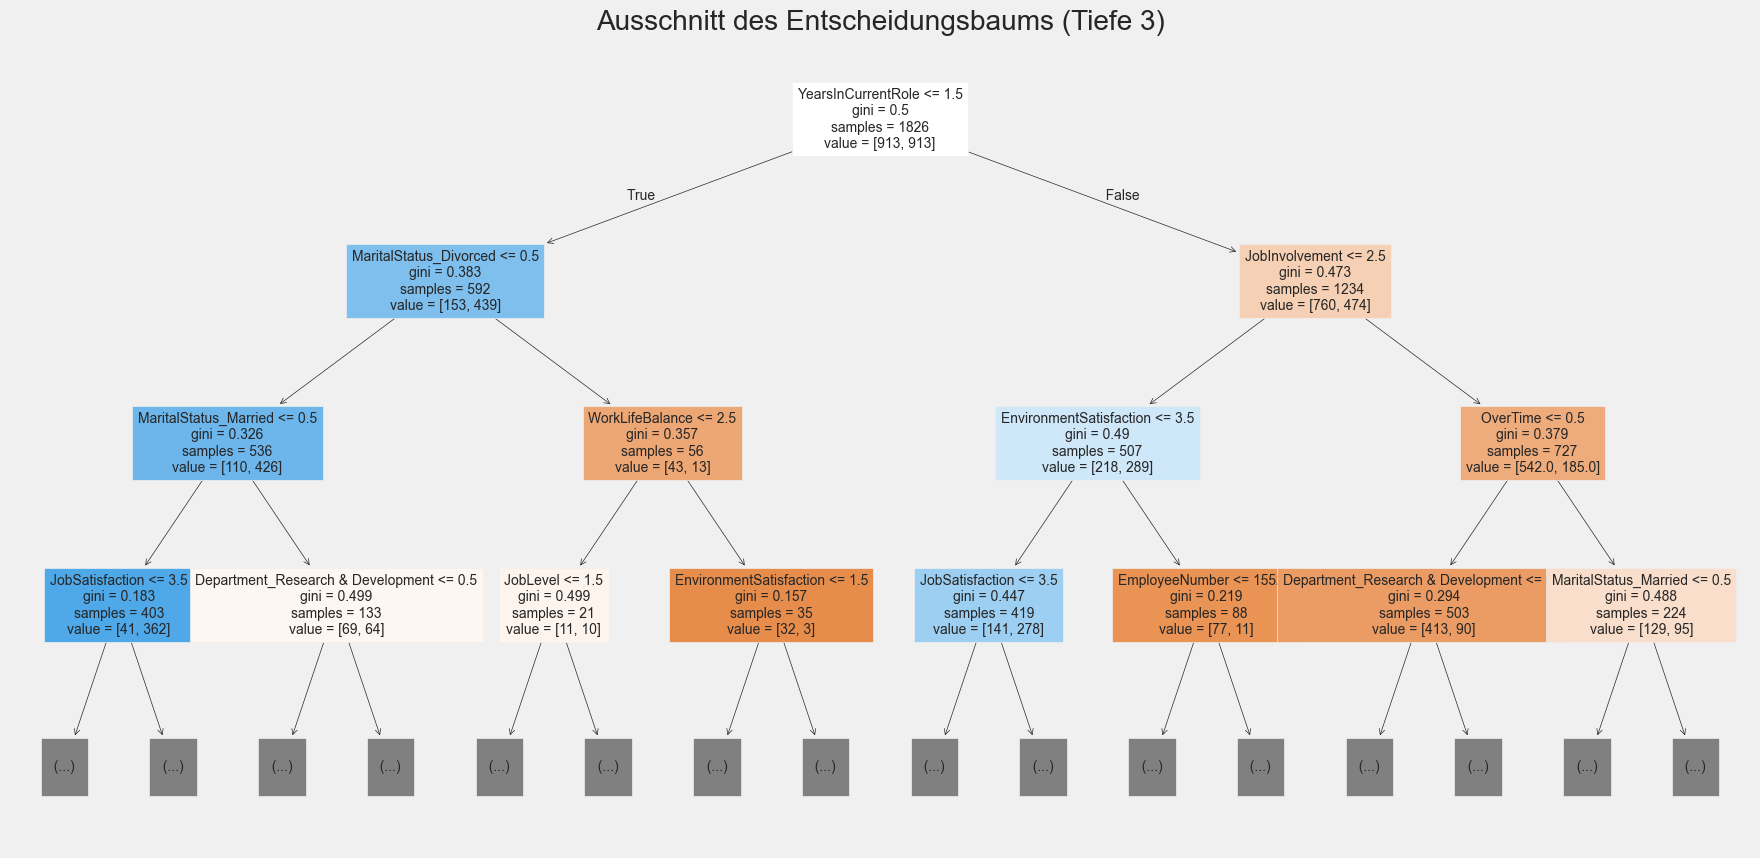

In [74]:
# Ausschnitt des Entscheidungsbaums visualisieren (z.B. nur bis Tiefe 3)
plt.figure(figsize=(20, 10))
plot_tree(tree_clf, feature_names=feature_names, filled=True, fontsize=10, max_depth=3)
plt.title("Ausschnitt des Entscheidungsbaums (Tiefe 3)")
plt.show()

Beim Hyperparameter-Tuning werden zunächst die Werte manuell festgelegt.
-	*criterion: gini*: Bewertung des Splits mittels Gini-Index. *log_loss* basiert auf logistische Verlustmaße, *entropy* verwendet Entropie (Unsicherheit/Unreinheit).
-	*splitter: best*: Wählt den besten Split auf Basis von *criterion*, *random*: Wählt einen zufälligen Split.
-	*max_depth*: Maximale Tiefe des Baumes.
-	*min_samples_split*: Minimale Anzahl an erforderlichen Samples um einen Knoten weiter zu splitten.
-	*min_samples_lead*: Minimale Anzahl erforderlicher Samples, die in einem Blattknoten vorhanden sein müssen. 

Mit diesen Parametern sind die Accuracy Scores sowohl im Test- als auch im Trainingsdatensatz im Vergleich zum Entscheidungsbaum ohne Optimierung niedriger. Das Modell zeigt also in den Trainingsdaten keine perfekte Genauigkeit mehr. Dies deutet auf einen bessere Generalisierbarkeit und eine reduzierte Überanpassung hin. Nach wie vor hat das Modell Schwierigkeiten, auf den Testdaten die Klasse Fluktuation korrekt zu identifizieren.

In [75]:
# Manuelle Festlegung der Parameter
manual_params = {
    "criterion": "gini",        # "gini" oder "entropy" oder "log_loss"
    "splitter": "best",         # "best" oder oder "random"
    "max_depth": 10,            # Wertebereich ab 1
    "min_samples_split": 2,     # Wertebereich ab 2
    "min_samples_leaf": 2       # Wertebereich ab 1
}

# Entscheidung für das Modell mit den festgelegten Parametern
tree_clf = DecisionTreeClassifier(random_state=42, **manual_params)
tree_clf.fit(X_resampled, y_resampled)

evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=True)
evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=False)

Train Result:
Accuracy Score: 96.50%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.942649    0.989619  0.964951     0.966134      0.966134
recall       0.990142    0.939759  0.964951     0.964951      0.964951
f1-score     0.965812    0.964045  0.964951     0.964928      0.964928
support    913.000000  913.000000  0.964951  1826.000000   1826.000000
_______________________________________________
Confusion Matrix: 
 [[904   9]
 [ 55 858]]

Test Result:
Accuracy Score: 76.63%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.887417   0.212121  0.766304    0.549769      0.799335
recall       0.837500   0.291667  0.766304    0.564583      0.766304
f1-score     0.861736   0.245614  0.766304    0.553675      0.781373
support    320.000000  48.000000  0.766304  368.000000    368.

Als weiterer Validierungsansatz soll Grid Search als bereits beschriebene Methode zur Parameteroptimierung angewandt werden. Insgesamt wurden 19494 verschiedene Parameterkombinationen getestet, was zu 97470 Trainingsvorgängen geführt hat. Die identifizierten Parameter deuten darauf hin, dass ein sehr einfacher Entscheidungsbaum mit maximaler Tiefe von 1 (ein Stumpf) die besten Ergebnisse während der Cross-Validation erzielt hat. Ein Baum mit dieser Konfiguration ist extrem einfach und trifft Entscheidungen basierend auf nur einem Merkmal. Dies hat allerdings zur Folge, dass der Entscheidungsbaum zwar nicht überanpasst, aber verfehlt dafür auch viele positive Instanzen (Fluktuation). Daraus lässt sich schließen, dass ein extrem einfacher Entscheidungsbaum nicht ausreichen leistungsfähig ist.

In [76]:
params = {
    "criterion":("gini", "entropy", "log_loss"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4, 5, 6, 7, 8, 9, 10], 
    "min_samples_leaf":list(range(1, 20)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(
    tree_clf, 
    params, 
    scoring="f1", 
    n_jobs=-1, 
    verbose=1, 
    cv=5
)

tree_cv.fit(X_resampled, y_resampled)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_resampled, y_resampled)
evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=True)
evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=False)

Fitting 5 folds for each of 19494 candidates, totalling 97470 fits
Best paramters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 9, 'splitter': 'random'})
Train Result:
Accuracy Score: 89.70%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.897043    0.897043  0.897043     0.897043      0.897043
recall       0.897043    0.897043  0.897043     0.897043      0.897043
f1-score     0.897043    0.897043  0.897043     0.897043      0.897043
support    913.000000  913.000000  0.897043  1826.000000   1826.000000
_______________________________________________
Confusion Matrix: 
 [[819  94]
 [ 94 819]]

Test Result:
Accuracy Score: 74.18%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.897527   0.223529  0.741848    0.560528      0.809614
recall   

In [ ]:
# Berechnen der ROC-Kurve und AUC
y_prob_dt = tree_clf.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = roc_auc_score(y_test, y_prob_dt)

# Plot der ROC-Kurve
plt.figure(figsize=(10, 6))
plt.plot(fpr_dt, tpr_rdt, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_dt:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForestClassifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##### *5.3 Random Forest*

Wie beim Entscheidungsbaum folgt zunächst die Anwendung des Random Forest ohne Parametertuning. Die Trainingsergebnisse weisen mit 65.66% eine moderate Genauigkeit (Accuracy Score) auf und scheint deshalb nicht in der Lage, die Labels (v.a. die Minderheitsklasse „Yes“) korrekt zu klassifizieren. Die Genauigkeit bei den Testdaten ist mit 72.83% höher als auf den Trainingsdaten und weist auf eine suboptimale Balance zwischen den Klassen hin. Auch hier zeigen die Bewertungsmetriken, wie Beispielsweise der Recall von 25.00%, dass das Modell mit sehr Yes-Instanzen verpasst. Nur 12 positive Labels wurden richtig klassifiziert, demgegenüber stehen 36 positive Labels, die fälschlicherweise als „No“ vorhergesagt wurden.

In [77]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_resampled, y_resampled)

evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=True)
evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=False)

Train Result:
Accuracy Score: 89.70%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.897043    0.897043  0.897043     0.897043      0.897043
recall       0.897043    0.897043  0.897043     0.897043      0.897043
f1-score     0.897043    0.897043  0.897043     0.897043      0.897043
support    913.000000  913.000000  0.897043  1826.000000   1826.000000
_______________________________________________
Confusion Matrix: 
 [[819  94]
 [ 94 819]]

Test Result:
Accuracy Score: 74.18%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.897527   0.223529  0.741848    0.560528      0.809614
recall       0.793750   0.395833  0.741848    0.594792      0.741848
f1-score     0.842454   0.285714  0.741848    0.564084      0.769836
support    320.000000  48.000000  0.741848  368.000000    368.

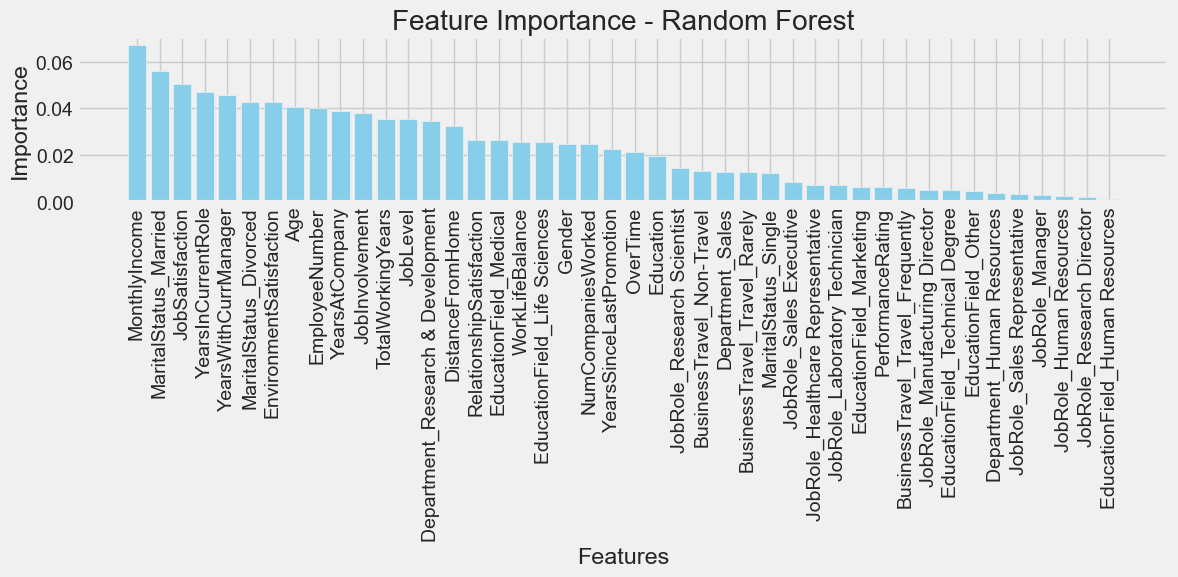

In [78]:
# Extrahieren der Feature Importance
feature_importances = rf_clf.feature_importances_
features = X_resampled.columns

# Erstellen eines DataFrames für die Darstellung
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sortieren nach Wichtigkeit
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualisierung der Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Als nächstes wird die Hyperparameter-Optimierung mithilfe von Random Search durchgeführt.*RandomizedSearchCV* verwendet Kreuzvalidierung und eine feste Anzahl von Parameterwerten aus angegebenen Verteilungen (durch Parameter *n_inter* definiert) Die Vorteile dieser Methode liegen in der Effizienz und Flexibilität, insbesondere wenn der Suchraum groß und Ressourcen begrenzt sind (Pedregosa et al. 2011). 

-	*n_estimators*: Anzahl der Bäume (hier Bereich von 200 bis 2000)
-	*min_weight_fraction_leaf*: Der minimale gewichtete Anteil der Gesamtsumme der Gewichte (aller Eingabestichproben), der an einem Blattknoten liegen muss.
-	*max_features*: Die Anzahl der Merkmale, die bei der Suche nach dem besten Split berücksichtigt werden sollen
-	*max_features*: Berücksichtigte Anzahl der Merkmale bei der Suche(*auto*: alle Features vs. *sqrt“: Wurzel der Gesamtzahl an Features)
-	*oob_score*: Ob Out-of-Bag-Stichproben verwendet werden sollen, um die Generalisierungsgenauigkeit zu schätzen.
-	*bootstrap*: *True* oder *False* ob Bootstrap-Sampling verwendet werden soll
-	*n_jobs*: hier werden alle verfügbaren Prozessoren und Paralellisierung verwendet

Die Kombinationen aus dem definierten Parameterbereich werden mit 5-facher Kreuzvalidierung und auf Basis des F1-Score (besonders nützlich, wenn Klassen unausgewogen) bewertet. Der optimierte Random Forest arbeitet mit 400 Entscheidungsbäumen, die Tiefe jedes Baumes ist auf maximal 30 begrenzt. 

Sowohl die Trainingsergebnisse als auch Testergebnisse zeigen im Vergleich zum Modell ohne Parametertuning keine Verbesserung der Leistung.

In [79]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['sqrt']
max_depth = [10, 20, 30, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators, 
    'max_features': max_features,
    'max_depth': max_depth, 
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf, 
    'bootstrap': bootstrap
}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(
    estimator=rf_clf, 
    scoring='recall',
    param_distributions=random_grid, 
    n_iter=10, 
    cv=5, 
    verbose=1, 
    random_state=42,
    n_jobs=-1
)

rf_cv.fit(X_resampled, y_resampled)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(X_resampled, y_resampled)

evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=True)
evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best paramters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False})
Train Result:
Accuracy Score: 89.70%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.897043    0.897043  0.897043     0.897043      0.897043
recall       0.897043    0.897043  0.897043     0.897043      0.897043
f1-score     0.897043    0.897043  0.897043     0.897043      0.897043
support    913.000000  913.000000  0.897043  1826.000000   1826.000000
_______________________________________________
Confusion Matrix: 
 [[819  94]
 [ 94 819]]

Test Result:
Accuracy Score: 74.18%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.897527   0.223529  0.741848    0.560528      0

Mittels der ROC-Kurve (Receiver Operating Characteristic) kann die Leistung von Klassifikationsmodelle visuell beurteilt werden. Indem sie die TPR (True Positive Rate) gegen die FÜR (Fals Positive Rate) aufträgt. Die Fläche unter der Kurve (AUC, bzw. Area Under the Curve) stellt die Fähigkeit eines Modells zur Unterscheidung dar, ob eine spezifische Bedingung vorhanden ist oder nicht. Ein AUC von 0,5 repräsentiert einen Test ohne Unterscheidungsfähigkeit (d. h., nicht besser als Zufall), während eine AUC von 1,0 einen Test mit perfekter Unterscheidung darstellt (Hoo et al. 2017). Im vorliegenden Fall deutet der AUC von 0.74 darauf hin, dass das Modell eine deutlich bessere Leistung als ein Zufallsmodell aufweist, hat jedoch Raum für Verbesserungen.

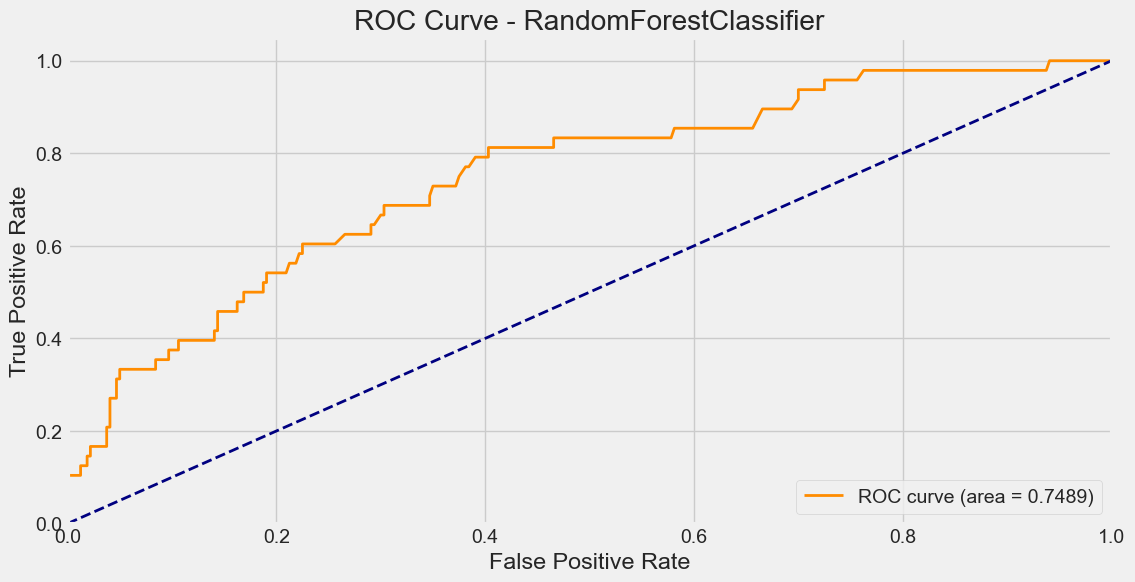

In [80]:
# Berechnen der ROC-Kurve und AUC für den RandomForestClassifier
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

# Plotten der ROC-Kurve für RandomForestClassifier
plt.figure(figsize=(12, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForestClassifier')
plt.legend(loc="lower right")
plt.show()

##### *5.4 XGBoost*

Zur Lösung der Klassifikationsaufgabe mittels XGBoost ist müssen die Labels in numerischer Form (binär 0 und 1) vorliegen und zunächst in den Pandas-Datentyp „category“ umgewandelt werden. 

In [81]:
# Erstellen und Trainieren des XGBoost Modells

# 1. Zielvariable in numerische Codes umwandeln (Yes --> 1, No --> 0)
if y_resampled.dtype == 'object':
    y_resampled = y_resampled.astype('category')
    y_resampled = y_resampled.cat.codes

if y_test.dtype == 'object':
    y_test = y_test.astype('category')
    y_test = y_test.cat.codes

if y.dtype == 'object':
    y = y.astype('category')
    y = y.cat.codes


Im ersten Schritt werden lediglich die für die Berechnung des Modells nötigen Parameter mit Standardwerten gesetzt:

- *objective*: Hier binäres Klassifikationsproblem mit einer logistischen Regression.
- *max_depth*: Maximale Tiefe jedes Entscheidungsbaum. Ein höherer Wert ermöglich komplexere Werte (Achtung: Overfitting).
- *learning_rate*: legt die Lernrate fest und steuert die Schrittweite des Gradientabstiegs. Ziel ist das Finden der optimalen Werte der Modellparameter zur Minimierung der Loss Function (Misst Fehler zwischen vorhergesagten und tatsächlichen Werten, z.B. Mean Squared Error bei linearen Regression oder Log-Loss bei binären Klassifikation). Ein niedriger Werte macht Modell robust ggü. Overfitting (Achtung: mehr Iterationen nötig).
- "n_estimators": Anzahl der Boosting-Runden. Jede Boosting-Runde (sequenzielles Training) fügt neuen Entscheidungsbaum hinzu und korrigiert die Fehler (Residuen) des vorherigen Baumes. Idee: Kombination vieler schwacher Modelle ergibt starkes Lernmodell.
- *"eval_metric"*: Metrik zur Evaluierung des Modells. "logloss" steht für logarithmischer Verlust (Logarithmic Loss) und bewertet wie gut das Klassifikationsmodell Wahrscheinlichkeiten für die Klassen vorhersagt. Hier *logloss* als Evaluationsmetrik um die Leistung des Modells während des Trainings zu bewerten (Ziel: Minimierung des logarithmischen Verlustes).


In [82]:
# Erstellen und Trainieren des XGBoost-Modells mit XGBClassifier
xgb_model = XGBClassifier(objective='binary:logistic', max_depth=6, learning_rate=0.3, n_estimators=100, eval_metric='logloss')
# xgb_model = XGBClassifier()
xgb_model.fit(X_resampled, y_resampled)

# Vorhersagen mit dem Modell
xgb_preds = xgb_model.predict(X_test)
xgb_y_pred = (xgb_preds > 0.5).astype(int)


Die Ergebnisse zeigen ein Trainingsresultat von 100% und somit eine perfekte Leistung. Auch hier ist Achtung vor Overfitting geboten. Mit einem Accuracy Score von 86.41% zeigt sich zwar eine signifikante Verschlechterung im Vergleich zu den Trainingsresultaten, aber die Genauigkeit ist immer noch hoch. Allerdings implizieren die Resultate auch bei diesem Modell eine geringere Präzision (47.37%) bei der Identifizierung bzw. Klassifikation der Minderheitsklasse (Fluktuation). Insgesamt wurden 300 Werte der Klasse 0 (keine Fluktuation) korrekt vorhergesagt und 20 fälschlicherweise als Klasse 0 klassifiziert (obwohl sie eigentlich der Klasse 1 entsprechen).Bei 30 Werten wiederum hat das Modell angenommen, dass sie der Klasse 0 angehören wobei es sich tatsächlich um Personen handelt, die das Unternehmen verlassen (Klasse 1).

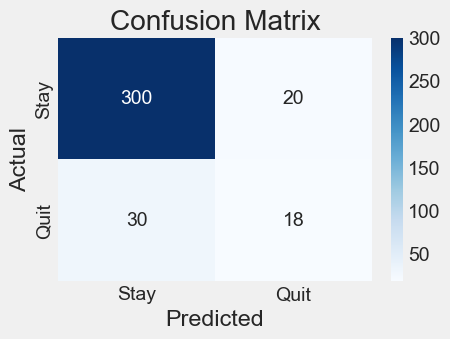

In [83]:
conf_matrix = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(4.5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Stay', 'Quit'], yticklabels=['Stay', 'Quit'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [84]:
evaluation(xgb_model, X_resampled, y_resampled, X_test, y_test, train=True )
evaluation(xgb_model, X_resampled, y_resampled, X_test, y_test, train=False )

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    913.0  913.0       1.0     1826.0        1826.0
_______________________________________________
Confusion Matrix: 
 [[913   0]
 [  0 913]]

Test Result:
Accuracy Score: 86.41%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.909091   0.473684   0.86413    0.691388      0.852299
recall       0.937500   0.375000   0.86413    0.656250      0.864130
f1-score     0.923077   0.418605   0.86413    0.670841      0.857276
support    320.000000  48.000000   0.86413  368.000000    368.000000
_______________________________________________
Conf

##### 2.3 Hyperparameter Tuning

Mit Hilfe von GridSearchCV kann aus einer Auswahl von Parametern die ideale Kombination ermittelt werden. 
Durch Verwendung von RandomSearchCV kann durch die Festlegung von Iterationen eine zufällig ideale Parameterkombination ermittelt werden.

- *max_depth:* Steuert, wie tief jeder einzelne Entscheidungsbaum wachsen kann. Größere Werte können zu komplexeren Modellen führen.
- *learning_rate (eta):* Kleinere Werte machen das Training langsamer, aber stabiler. Ein niedrigerer Wert erfordert oft mehr n_estimators.
- *n_estimators:* Gibt an, wie viele Bäume im Modell trainiert werden. Mehr Bäume können zu besseren Modellen führen, aber auch die Rechenzeit erhöhen.
- *subsample:* Der Anteil der Trainingsdaten, die für jede Boosting-Runde zufällig ausgewählt werden. Reduziert Overfitting, Werte zwischen 0.5 und 1.0 sind üblich.
- *colsample_bytree:* Der Anteil der Merkmale, die für das Training jedes Baumes zufällig ausgewählt werden. Reduziert Overfitting, indem es die Vielfalt der Bäume erhöht. Werte zwischen 0.5 und 1.0 sind üblich.
- *reg_alpha (alpha):* L1-Regularisierungsterm, der eine Strafe für die Summe der absoluten Werte der Koeffizienten hinzufügt. Fördert Sparsamkeit im Modell, indem es einige Koeffizienten auf genau Null setzt, was effektiv einer Feature-Auswahl entspricht und Overfitting reduziert.
- *reg_lambda (lambda):* L2-Regularisierungsterm, der eine Strafe für die Summe der Quadrate der Koeffizienten hinzufügt. Stabilisiert das Modell, indem es alle Koeffizienten schrumpft, um Überanpassung zu reduzieren, ohne sie auf Null zu setzen, was zu einem glatteren und weniger komplexen Modell führt.
- *gamma:* Mindesteste Verlustreduktion, die erforderlich ist, um eine Baumaufspaltung durchzuführen. Höhere Werte führen dazu, dass weniger Splits durchgeführt werden, was zu einfacheren und weniger overfitted Modellen führt.

Wie im Data Understanding bereits festgestellt wurde, ist die Zielvariable "Attrition" unausgeglichen ist. 1.233 (84%) Mitarbeitende haben das Unternehmen nicht verlassen, während nur 237 (16%) gegangen sind. XGBoost hat einen speziellen Parameter scale_pos_weight für unausgeglichene Klassen.
- *scale_pos_weight:* Kontrolliert das  Gleichgewicht zwischen positiven und negativen Werten. Der Wert wird verwendet, um den Gradienten für die positive Klasse zu skalieren. Dies hat zur Folge, dass das Modell beim Training der positiven Klasse Skalierungsfehler macht und das Modell dazu ermutigt, diese zu stark zu korrigieren. Dies kann wiederum dazu beitragen, dass das Modell eine bessere Leistung erzielt, wenn es Vorhersagen für die positive Klasse trifft. Wenn es zu weit geht, kann es dazu führen, dass das Modell die positive Klasse besser vorhersagt, was jedoch zu einer schlechteren Leistung der negativen Klasse oder beider Klassen führt. Ein typischer Wert wäre sum(negative instances) / sum(positive instances).



In [85]:
# Random Search: Definiere Parametergrenzen
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.1, 0.5),
    'subsample': uniform(0, 0.8),
    'colsample_bytree': uniform(0, 1),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'scale_pos_weight': randint(1,50)
}

# RandomizedSearchCV starten, n_iter gibt an, wieviele Iterationen durchgeführt werden
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=1,
    n_jobs=-1
)

# Fit
random_search.fit(X_resampled, y_resampled)

print(f"Best Parameter: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameter: {'colsample_bytree': 0.7110953188954077, 'learning_rate': 0.1967302846363623, 'max_depth': 9, 'n_estimators': 122, 'reg_alpha': 0.31984891724102216, 'reg_lambda': 0.604480007052297, 'scale_pos_weight': 34, 'subsample': 0.7782300735461242}
Best Score: 0.8668714797747056


In [86]:
# Grid Search: Definiere Parameter, je mehr Parameter betrachtet werden sollen, desto länger dauert die Suche
# Daher werden hier nicht alle Variablen betrachtet 

param_grid = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [80, 100, 120],
    'subsample': [0.4, 0.6, 0.8],
    'colsample_bytree':[0.1, 0.2, 0.3],
    'scale_pos_weight' :[4, 6, 8]
    #'reg_alpha': [0, 0.01, 0.1, 1],
    #'reg_lambda': [0, 0.01, 0.1, 1],
    # 'gamma': [0, 0.1, 0.5, 1]

}

# Grid Search durchführen
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=3)
grid_search.fit(X_resampled, y_resampled)


print(f"Best Parameter: {grid_search.best_params_}, BEst Score: {grid_search.best_score_}")

Best Parameter: {'colsample_bytree': 0.3, 'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 100, 'scale_pos_weight': 4, 'subsample': 0.8}, BEst Score: 0.8801870740007787


In [87]:
# Erstellen und Trainieren des XGBoost-Modells mit angepassten Parametern
xgb_model = XGBClassifier(objective='binary:logistic',
                          max_depth=7, 
                          learning_rate=0.2, 
                          n_estimators=120,
                          subsample=0.6,
                          colsample_bytree=0.2,
                          scale_pos_weight=6, 
                          eval_metric='logloss')
# xgb_model = XGBClassifier()
xgb_model.fit(X_resampled, y_resampled)

# Vorhersagen mit dem Modell
xgb_preds = xgb_model.predict(X_test)
xgb_y_pred = (xgb_preds > 0.5).astype(int)

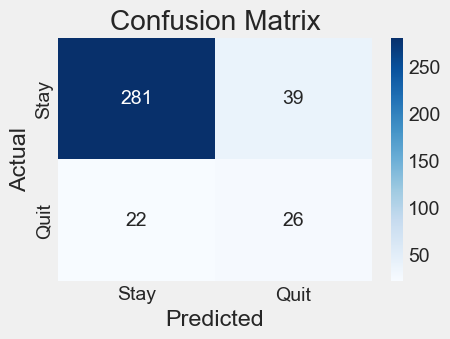

In [88]:
conf_matrix = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(4.5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Stay', 'Quit'], yticklabels=['Stay', 'Quit'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Je höher der Parameter scale_pos_weight gesetzt wird, um so mehr verbessert sich die Vorhersage für die positive Klasse. Trotz eines relativ hohen scale_pos_weight, ist die Vorhersagegüte für die positive Klasse (Quit) weiterhin nicht gut. Im Testdatensatz wurde nur knapp die Hälfte der Personen, die das Unternehmen tatsächlich verlassen korrekt vorhergesagt. Bei etwas mehr als der Hälfte wurde hingegen vorhergesagt, dass sie das Unternehmen nicht verlassen.

In [89]:
evaluation(xgb_model, X_resampled, y_resampled, X_test, y_test, train=True )
evaluation(xgb_model, X_resampled, y_resampled, X_test, y_test, train=False )

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    913.0  913.0       1.0     1826.0        1826.0
_______________________________________________
Confusion Matrix: 
 [[913   0]
 [  0 913]]

Test Result:
Accuracy Score: 83.42%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.927393   0.400000  0.834239    0.663696      0.858602
recall       0.878125   0.541667  0.834239    0.709896      0.834239
f1-score     0.902087   0.460177  0.834239    0.681132      0.844446
support    320.000000  48.000000  0.834239  368.000000    368.000000
_______________________________________________
Conf

Durch die angepasste Parameterkonfigurationen hat sich der Accuracy Score zwar von 86,41 % auf 83,15 % verschlechtert. Allerdings wurde der Recall-Score (misst die Fähigkeit, alle positiven Fälle zu finden (Verhältnis positiver Vorhersagen zu tatsächlich positive Werten)) von 37,5 % auf 47,9 % verbessert.

##### 2.4 Visualisierung der Modellperformance

Die *ROC-Curve* (Receiver Operating Characteristic) ist ein Tool zur Bewertung der Leistung eines binären Klassifikationsmodells. Sie stellt die wahre positive Rate (True Positive Rate, TPR) gegenüber der falschen positiven Rate (False Positive Rate, FPR) dar, um die Trennschärfe des Modells bei verschiedenen Schwellenwerten zu visualisieren

In [90]:
# Berechnen der FPR, TPR und AUC
fpr_xgb_model, tpr_xgb_model, _ = roc_curve(y_test, xgb_preds)
roc_auc_xgb_model = roc_auc_score(y_test, xgb_preds)

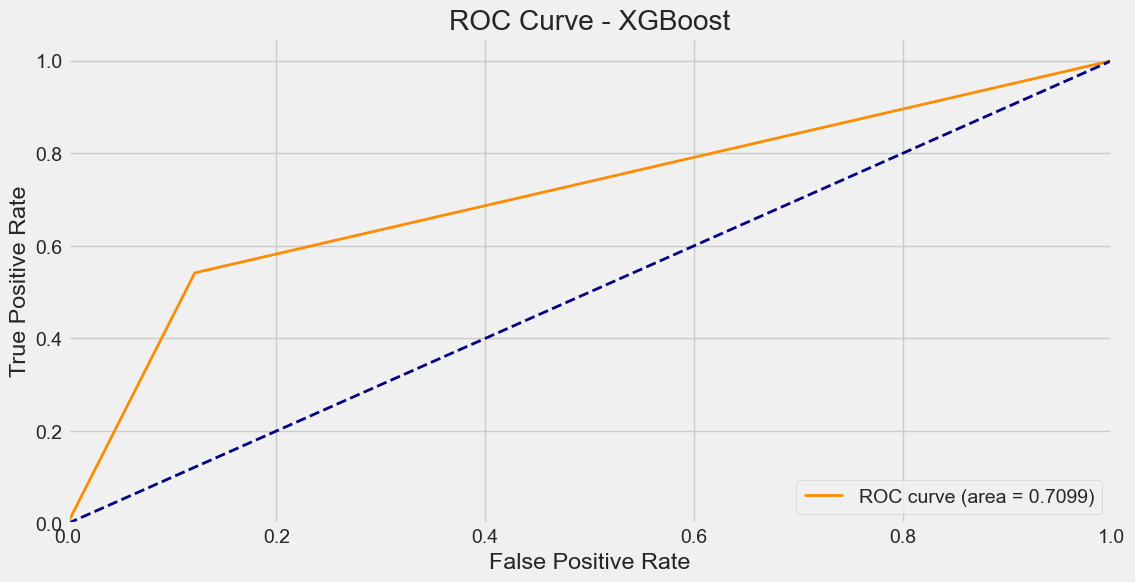

In [91]:
# Plotten der ROC-Kurve für XGBoost
plt.figure(figsize=(12, 6))
plt.plot(fpr_xgb_model, tpr_xgb_model, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb_model:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")

##### 2.5 Kreuzvalidierung

Mit Kreuzvalidierung kann geprüft werden, wie gut ein Modell auf neue Daten angewendet werden kann. Dafür wird das Modell k-mal trainiert mit unterschiedlich großen Teilmengen. Die Modelleistung wird für jeden Durchlauf gemessen und ein Durchschnitt berechnet.

In [92]:
# Kreuzvalidierung
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cross_val_results = cross_val_score(xgb.XGBClassifier(objective='binary:logistic',
                          max_depth=7, 
                          learning_rate=0.2, 
                          n_estimators=120,
                          subsample=0.6,
                          colsample_bytree=0.2,
                          scale_pos_weight=6, 
                          eval_metric='logloss'), X, y, cv=kfold, scoring='f1')
print(f"Cross-Validation f1: {cross_val_results.mean()} +/- {cross_val_results.std()}")

Cross-Validation f1: 0.475147293833861 +/- 0.052554154319935924


##### 2.6 Vergleich Modell-Performance mit Daten im Originalformat vs. bereinigte Daten (One-Hot-Encoding)

Verbessert sich die ROC-Curve, wenn XGBoost auf den Originaldaten (Datentyp Object, der für XGBoost in kategoriale Variablen umgewandelt wird) anstatt auf den mittels One-Hot Encoding bereinigten Daten ausgeführt wird?

Hierfür wird der Datensatz employee_data_transformed benötigt. Dieser wird auf die gleiche Weise aufgeteilt in Trainings- und Testdaten wie der Datensatz employee_data (s.o.). Außerdem wird auch in diesem Datensatz mitttels SMOTE eine Gleichgewichtung der Zielvariablen erzeugt.

In [93]:
# Datenvorbereitung
categorical_col = []
for column in employee_data_transformed.columns:
    if employee_data_transformed[column].dtype == object:
        categorical_col.append(column)
for column in categorical_col:
    employee_data_transformed[column] = employee_data_transformed[column].astype("category").cat.codes
employee_data_transformed['Attrition'] = employee_data_transformed['Attrition'].astype("category").cat.codes

#Aufteilen der Daten in Zielvariable X_2 und Attribute y_2.
X_2 = employee_data_transformed.drop('Attrition', axis=1).values  # Merkmale als NumPy-Array
y_2 = employee_data_transformed['Attrition'].values               # Zielvariable als NumPy-Array

#Aufteilen der Daten in Test und Trainingsdaten.
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.25, random_state=42)

smote = SMOTE(random_state=42)
X_2_resampled, y_2_resampled = smote.fit_resample(X_2_train, y_2_train)

# Zählen der Anzahl der "Yes"-Labels (Attrition = 1) vor SMOTE
num_yes_before = np.sum(y_2_train == 1)
print(f"Anzahl der 'Yes' (Attrition = 1) vor SMOTE: {num_yes_before}")
num_yes_after = np.sum(y_2_resampled == 1)
print(f"Anzahl der 'Yes' (Attrition = 1) nach SMOTE: {num_yes_after}")


Anzahl der 'Yes' (Attrition = 1) vor SMOTE: 189
Anzahl der 'Yes' (Attrition = 1) nach SMOTE: 913


In [94]:
X_2 = employee_data_transformed.drop('Attrition', axis=1) # Zielvariable entfernen
y_2 = employee_data_transformed['Attrition']  # 'Attrition' Spalte als Series

# Train-Test-Split durchführen
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.25, random_state=42)

# Textfeatures in Kategorien umwandeln
categories = X_2_train.select_dtypes(include=object).columns.tolist()
for col in categories:
    X_2_train[col] = X_2_train[col].astype('category')
    X_2_test[col] = X_2_test[col].astype('category')

# Labels in numerische Codes umwandeln
if y_2_train.dtype == 'object':
    y_2_train = y_2_train.astype('category')
    y_2_train = y_2_train.cat.codes

if y_2_test.dtype == 'object':
    y_2_test = y_2_test.astype('category')
    y_2_test = y_2_test.cat.codes


smote = SMOTE(random_state=42)
X_2_resampled, y_2_resampled = smote.fit_resample(X_2_train, y_2_train)

# Zählen der Anzahl der "Yes"-Labels (Attrition = 1) vor SMOTE
num_yes_before = np.sum(y_2_train == 1)
print(f"Anzahl der 'Yes' (Attrition = 1) vor SMOTE: {num_yes_before}")
num_yes_after = np.sum(y_2_resampled == 1)
print(f"Anzahl der 'Yes' (Attrition = 1) nach SMOTE: {num_yes_after}")

Anzahl der 'Yes' (Attrition = 1) vor SMOTE: 189
Anzahl der 'Yes' (Attrition = 1) nach SMOTE: 913


In [95]:
# Erstellen der DMatrix
# DMatrix ist eine spezielle Datenstruktur, die von XGBoost verwendet wird.
# "enable_categorial=True" ermöglich die Verarbeitung kategorialer Daten

dtrain_reg = xgb.DMatrix(X_2_resampled, y_2_resampled, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_2_test, y_2_test, enable_categorical=True)

# Modell trainieren

params = {
    'objective': 'binary:logistic',
    'max_depth': 7,
    'eta': 0.2,
    'subsample': 0.6,
    'colsample_bytree':0.2,
    'scale_pos_weight':6,
    'eval_metric': 'logloss'
}
xgb_model_2 = xgb.train(params, dtrain_reg, num_boost_round=120)

In [96]:
# Vorhersagen
y_pred_prob_2 = xgb_model_2.predict(dtest_reg)
y_pred_2 = (y_pred_prob_2 > 0.5).astype(int)


# Genauigkeit berechnen
accuracy = accuracy_score(y_2_test, y_pred_2)
mse = mean_squared_error(y_2_test, y_pred_prob_2)
rmse = np.sqrt(mse)
auc = roc_auc_score(y_2_test, y_pred_prob_2) 
fpr_xgb_model_2, tpr_xgb_model_2, _ = roc_curve(y_2_test, y_pred_prob_2)

print(f"Accuracy: {accuracy}")
print(f"mse: {mse}")
print(f"rmse: {rmse}")
print(f"Area under Curve: {auc}")

Accuracy: 0.7907608695652174
mse: 0.14915552735328674
rmse: 0.38620659708976746
Area under Curve: 0.7578776041666667


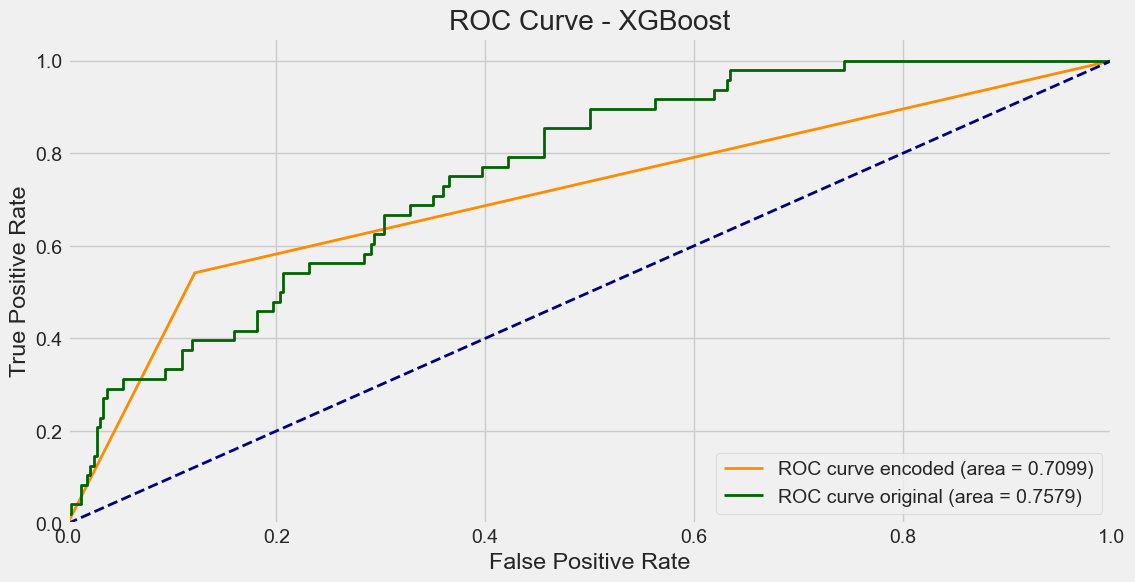

In [97]:
# Plotten der ROC-Kurve für XGBoost
plt.figure(figsize=(12, 6))
plt.plot(fpr_xgb_model, tpr_xgb_model, color='darkorange', lw=2, label=f'ROC curve encoded (area = {roc_auc_xgb_model:0.4f})')
plt.plot(fpr_xgb_model_2, tpr_xgb_model_2, color='darkgreen', lw=2, label=f'ROC curve original (area = {auc:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")

##### 2.7 Visualisierung der Feature Importance und des Entscheidungsbaums

Der Feature Importance Plot berechnet, wie häufig das Feature verwendet wurde, um Entscheidungsbäume im Modell aufzuteilen. Nachfolgend wird die unterschiedliche Gewichtung der Features in Abhängigkeit der zugrunde liegenden Daten (Encoded oder original) dargestellt.

EmployeeNumber und Monthly Income sind in beiden Fällen sehr wichtig für die Aufteilung der Entscheidungsbäume. Beim Encoded Datensatz führt mit Abstand das MonthlyIncome, beim Original Datensatz mit Abstand die EmployeeNumber das Ranking an.

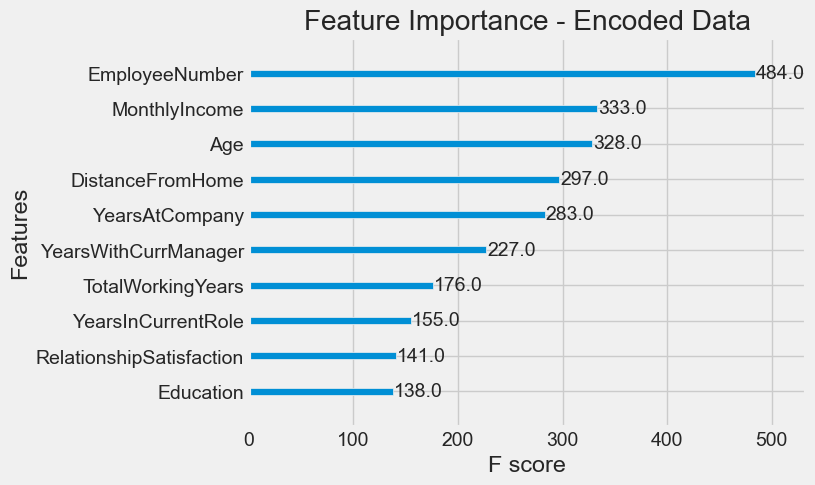

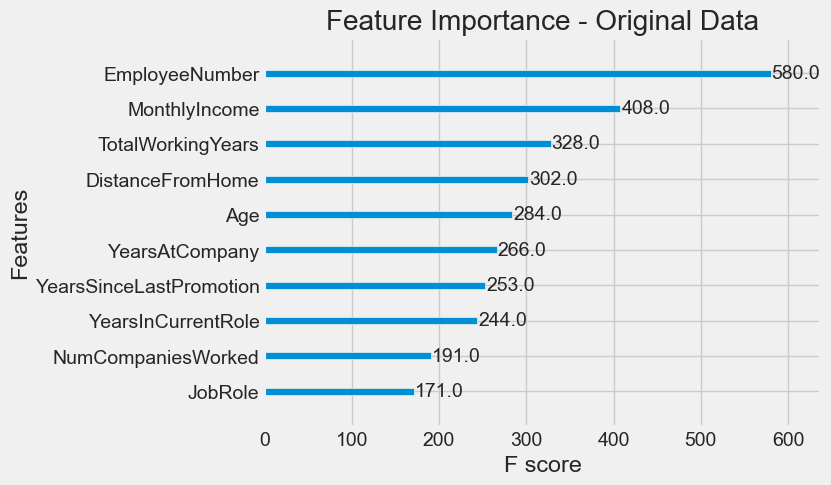

In [98]:

xgb.plot_importance(xgb_model, importance_type="weight", max_num_features =10, title='Feature Importance - Encoded Data')
plt.show()

xgb.plot_importance(xgb_model_2, importance_type="weight", max_num_features =10, title='Feature Importance - Original Data')
plt.show()


Um die Entscheidungsregeln und die Struktur der Bäume besser zu verstehen, kann man sich diese grafisch darstellen lassen. Bei einer maximalen Tiefe von 7 wird der Baum allerdings schon sehr unübersichtlich.

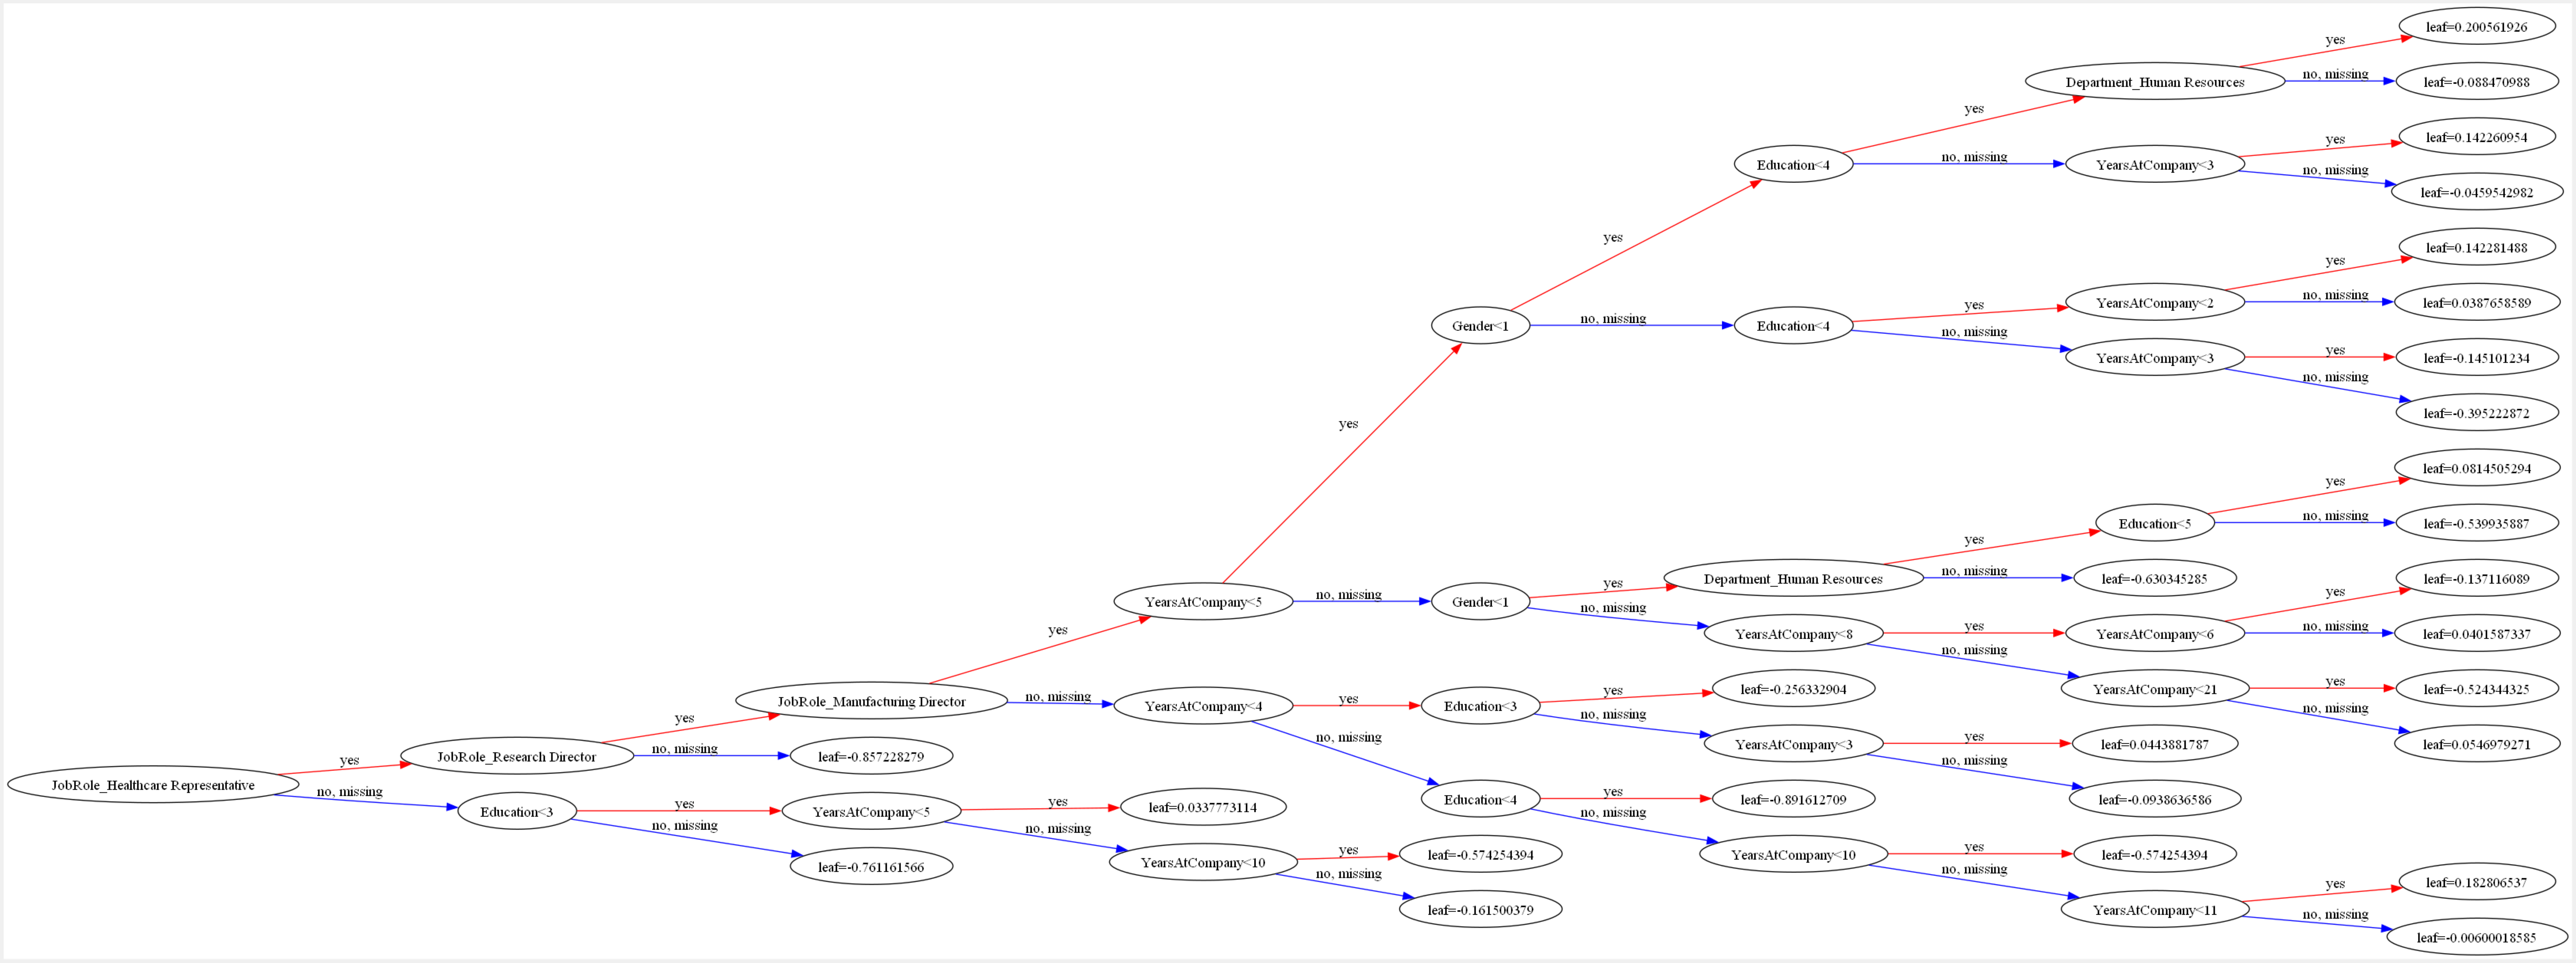

In [99]:
# plot des Entscheidungsbaumes
fig, ax = plt.subplots(figsize=(80,50)) 
xgb.plot_tree(xgb_model, num_trees=0, rankdir = 'LR',  ax=ax)
plt.show()

#### 3. SVM

Die Support Vector Machine (SVM) ist ein überwachter Lernalgorithmus, der versucht das Risiko von Overfitting zu verringern. Bei der SVM wird jedes Mitglied des Trainingsdatensatzes einer vor zwei Kategorien zugewiesen, sodass es sich um einen nicht-probabilistischen binären linearen Klassifikator handelt. Bei einer linearen Klassifikation werden die Eingabetrainingsdatenpunkte in einem Raum (Hyperplane) abgebildet, jeder mit einem anderen Klassenlabel, das durch eine klare Lücke voneinander getrennt ist. Neue Datenpunkte werden dann in denselben Raum abgebildet und als Teil einer Klasse vorhergesagt, je nachdem, auf welcher Seite der Lücke sie liegen. SVM kann aber auch nicht-lineare Klassifikationen durchführen. Nebst der Robustheit gegenüber Überanpassung liegt der Vorteil in der Effektivität in hochdimensionalen Räumen (also wenn die Anzahl der Merkmale größer als die Anzahl an Beobachtungen ist). Durch verschiedene Kernel-Funktionen (darunter linear, polynominal und sigmoid) sind SVMs flexibel auf verschiedene Datensätze und Problemtypen einsetzbar. Allerdings gestaltet sich die Modellauswahl mitunter durch das Hyperparameter-Tuning und die Kernel-Auswahl als komplex. Unter der Modellkomplexität leidet ebenfalls die Interpretierbarkeit (Cortes und Vapnik 1995).

In [100]:
# Erstellen und trainieren des SVM Modells 
svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm.fit(X_resampled, y_resampled)
evaluation(svm, X_resampled,  y_resampled, X_test, y_test, train=True)
evaluation(svm, X_resampled,  y_resampled, X_test, y_test, train=False)

Train Result:
Accuracy Score: 64.02%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.626482    0.657248  0.640197     0.641865      0.641865
recall       0.694414    0.585980  0.640197     0.640197      0.640197
f1-score     0.658701    0.619572  0.640197     0.639136      0.639136
support    913.000000  913.000000  0.640197  1826.000000   1826.000000
_______________________________________________
Confusion Matrix: 
 [[634 279]
 [378 535]]

Test Result:
Accuracy Score: 73.10%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.893238   0.206897  0.730978    0.550067      0.803716
recall       0.784375   0.375000  0.730978    0.579688      0.730978
f1-score     0.835275   0.266667  0.730978    0.550971      0.761108
support    320.000000  48.000000  0.730978  368.000000    368.

Verwendeter Kern: rbf - Auch als Gaussian Kernel bezeichnet, misst er die Ähnlichkeit der Datenpunkte, indem er den euklidischen Abstand in den exponentiellen Term einbezieht. Das dieser Kern besonders effektiv bei komplexen und nichtlinearen Mustern ist, ist er im Falle dieses Datensatzes geeignet. 

PCA wird angewendet, um die Dimensionen des hochdimensionalen HR-Datensatzes zu reduzieren, der 40 Merkmale umfasst. Diese Technik transformiert die Daten in einen kleineren Raum (z. B. 2D), indem sie die Hauptkomponenten wählt, die die meiste Varianz erklären. Dies erleichtert die Visualisierung und Interpretation des Modells, insbesondere bei der Darstellung von Entscheidungsgrenzen des SVM-Modells in zwei Dimensionen. Außerdem hilft PCA, irrelevante oder korrelierte Merkmale zu entfernen, was die Effizienz und Performance des Modells verbessern kann.

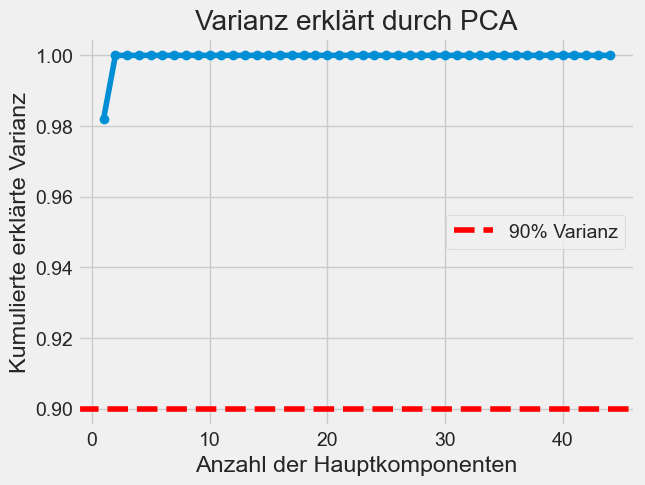

In [101]:
pca = PCA()
pca.fit(X_resampled) 
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Anzahl der Hauptkomponenten')
plt.ylabel('Kumulierte erklärte Varianz')
plt.title('Varianz erklärt durch PCA')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Varianz')
plt.legend(loc='best')
plt.show()

In [102]:
# PCA-Komponenten und ihre Bedeutung für die ursprünglichen Features
components = pca.components_
features = X_resampled.columns  # Namen der Features

# Ausgabe der ersten zwei Hauptkomponenten
for i in range(2):  # oder die Anzahl der gewünschten Komponenten
    component = components[i]
    feature_importance = sorted(zip(features, component), key=lambda x: abs(x[1]), reverse=True)
    print(f"Hauptkomponente {i + 1}:")
    for feature, importance in feature_importance:
        print(f"{feature}: {importance:.4f}")

Hauptkomponente 1:
MonthlyIncome: 1.0000
EmployeeNumber: -0.0027
TotalWorkingYears: 0.0014
Age: 0.0011
YearsAtCompany: 0.0008
YearsInCurrentRole: 0.0004
YearsWithCurrManager: 0.0003
YearsSinceLastPromotion: 0.0003
JobLevel: 0.0002
NumCompaniesWorked: 0.0001
DistanceFromHome: -0.0001
Education: 0.0000
JobRole_Manager: 0.0000
JobRole_Research Scientist: -0.0000
JobRole_Laboratory Technician: -0.0000
JobRole_Research Director: 0.0000
RelationshipSatisfaction: 0.0000
WorkLifeBalance: 0.0000
MaritalStatus_Married: 0.0000
BusinessTravel_Travel_Rarely: 0.0000
Department_Sales: 0.0000
JobRole_Sales Executive: 0.0000
Gender: 0.0000
JobRole_Sales Representative: -0.0000
MaritalStatus_Single: -0.0000
EducationField_Medical: 0.0000
Department_Research & Development: -0.0000
JobInvolvement: 0.0000
JobRole_Manufacturing Director: 0.0000
EducationField_Marketing: 0.0000
MaritalStatus_Divorced: 0.0000
JobSatisfaction: 0.0000
EnvironmentSatisfaction: 0.0000
JobRole_Healthcare Representative: 0.0000
Ove

In [103]:
# Dimensionsreduktion mit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

# Trainieren des SVM-Modells auf den reduzierten Daten
svm_pca = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm_pca.fit(X_pca, y_resampled)

SVC(probability=True, random_state=42)

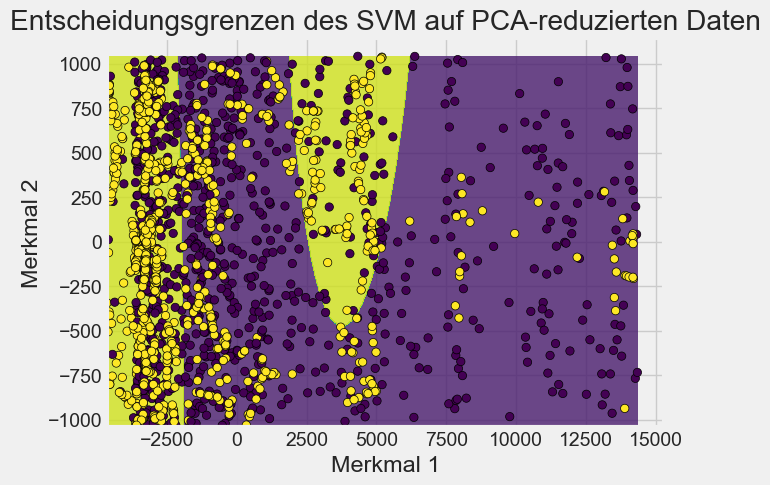

In [104]:
# Visualisierung der Entscheidungsgrenzen
def plot_decision_boundary(X, y, model, title='Entscheidungsgrenze'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 8),
                         np.arange(y_min, y_max, 8))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.viridis)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.viridis)
    plt.title(title)
    plt.xlabel('Merkmal 1')
    plt.ylabel('Merkmal 2')
    plt.show()

# Plot der Entscheidungsgrenzen
plot_decision_boundary(X_pca, y_resampled, svm_pca, title='Entscheidungsgrenzen des SVM auf PCA-reduzierten Daten')

In [105]:
evaluation(svm_pca, X_pca,  y_resampled, X_test, y_test, train=True)

Train Result:
Accuracy Score: 65.33%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.666667    0.641988  0.653341     0.654327      0.654327
recall       0.613363    0.693319  0.653341     0.653341      0.653341
f1-score     0.638905    0.666667  0.653341     0.652786      0.652786
support    913.000000  913.000000  0.653341  1826.000000   1826.000000
_______________________________________________
Confusion Matrix: 
 [[560 353]
 [280 633]]



Das PCA-Reduzierte Datenset verbessert die Ergebnisse des Modells nicht.  
Mithilfe von GridSearch wird nun eine geeignete Parameterkombination identifiziert. 

Der **Parameter C** bestimmt den Trade-off zwischen der Maximierung des Margins und der Minimierung der Klassifikationsfehler. Ein kleiner Wert von C legt mehr Gewicht auf eine größere Margin, während ein größerer Wert von C versucht, die Trainingsfehler zu minimieren.
Wirkung:
Ein kleines C: Führt zu einer weicheren Margin und kann Modelle erzeugen, die robuster gegen Rauschen in den Trainingsdaten sind, aber möglicherweise nicht alle Datenpunkte korrekt klassifizieren.
Ein großes C: Führt zu einer härteren Margin, was das Modell stärker an die Trainingsdaten anpasst, was potenziell zu Overfitting führen kann.


Der Parameter **gamma** beeinflusst die Form des rbf (Radial Basis Function) Kernels. Er bestimmt, wie stark ein einzelner Trainingspunkt die Entscheidungsgrenze beeinflusst.
Wirkung:
Ein kleines gamma: Weite Entscheidungsfläche, weniger kompliziertes Modell, könnte aber zu Underfitting führen.
Ein großes gamma: Engere Entscheidungsfläche um Datenpunkte herum, was zu komplexeren Modellen führen kann, die jedoch anfällig für Overfitting sind.

In [128]:
svm = SVC(random_state=42)

param_grid = [
    {'C': [0.1, 1, 6, 10], 'gamma': [0.001, 0.005, 0.01], 'kernel': ['rbf']},
]


search = GridSearchCV(svm, param_grid=param_grid, scoring='f1', cv=3, refit=True, verbose=1)
search.fit(X_resampled, y_resampled)

best_params = search.best_params_
print(f"Beste Parameter: {best_params}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Beste Parameter: {'C': 6, 'gamma': 0.001, 'kernel': 'rbf'}


In [131]:
svm = SVC(**best_params, probability=True)
svm.fit(X_resampled, y_resampled)

evaluation(svm, X_resampled,  y_resampled, X_test, y_test, train=True)
evaluation(svm, X_resampled,  y_resampled, X_test, y_test, train=False)

Train Result:
Accuracy Score: 99.95%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    1.000000    0.998906  0.999452     0.999453      0.999453
recall       0.998905    1.000000  0.999452     0.999452      0.999452
f1-score     0.999452    0.999453  0.999452     0.999452      0.999452
support    913.000000  913.000000  0.999452  1826.000000   1826.000000
_______________________________________________
Confusion Matrix: 
 [[912   1]
 [  0 913]]

Test Result:
Accuracy Score: 75.82%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision    0.86901   0.127273  0.758152    0.498141      0.772261
recall       0.85000   0.145833  0.758152    0.497917      0.758152
f1-score     0.85940   0.135922  0.758152    0.497661      0.765033
support    320.00000  48.000000  0.758152  368.000000    368.00000

##### Visualisierung der Modellperformance

Die *ROC-Curve* (Receiver Operating Characteristic) ist ein Tool zur Bewertung der Leistung eines binären Klassifikationsmodells. Sie stellt die wahre positive Rate (True Positive Rate, TPR) gegenüber der falschen positiven Rate (False Positive Rate, FPR) dar, um die Trennschärfe des Modells bei verschiedenen Schwellenwerten zu visualisieren

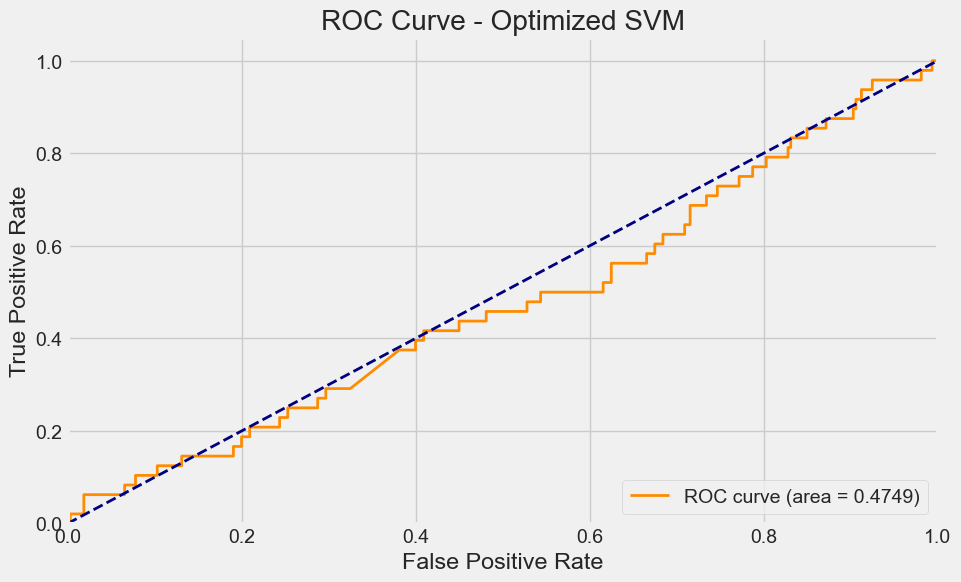

In [132]:
y_prob_svm = svm.predict_proba(X_test)[:,1]

# Berechnen der ROC-Kurve und AUC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)



# Plot der ROC-Kurve
plt.figure(figsize=(10, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Optimized SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Vergleich der Methoden 
Im Folgenden werden die zuvor angewendeten Modelle SVM, XGBoost und Random Forest verglichen um zu bewerten, welches Modell die besten Ergebnisse liefert. 

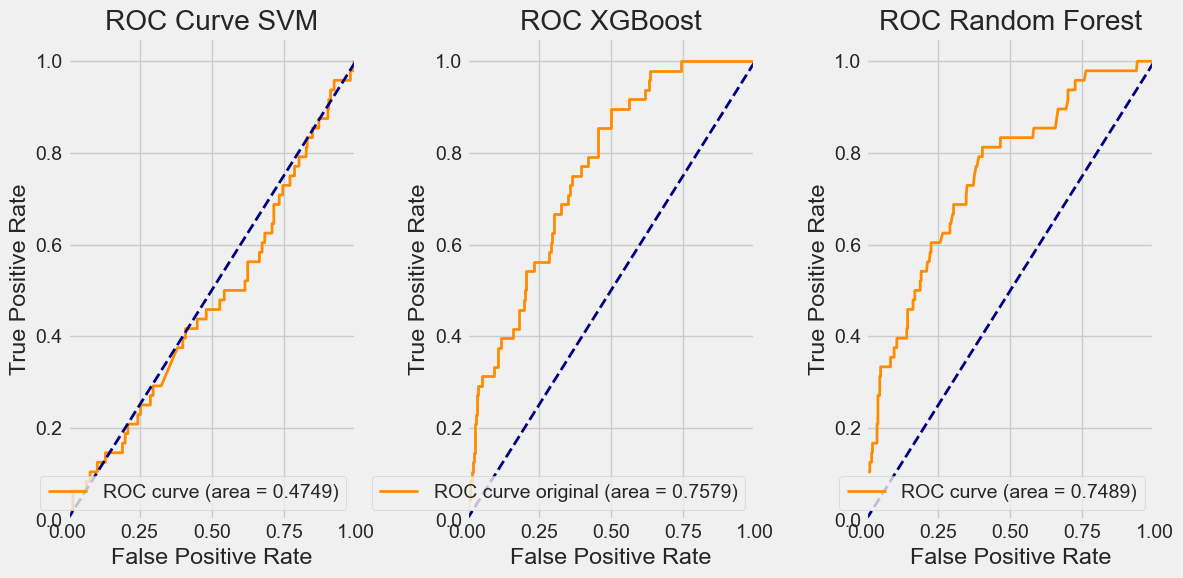

In [133]:
# Plotten der ROC-Kurven der verschiedenen Modelle
plt.figure(figsize=(12, 6))

# ROC-Kurve vor dem Tuning
plt.subplot(1, 3, 1)
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM')
plt.legend(loc="lower right")

# ROC-Kurve XGBoost
plt.subplot(1, 3, 2)
plt.plot(fpr_xgb_model_2, tpr_xgb_model_2, color='darkorange', lw=2, label=f'ROC curve original (area = {auc:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC XGBoost')
plt.legend(loc="lower right")

# ROC-Kurve Random Forest
plt.subplot(1, 3, 3)
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Random Forest')
plt.legend(loc="lower right")

plt.tight_layout()

### Erklärung der Vorhersagen mittels SHAP

SHapley Additive exPlanations (SHAP) ist eine Methode zur Erklärung der Vorhersagen von Machine-Learning-Modellen. In XGBoost wird SHAP verwendet, um die Beitrage einzelner Merkmale zu den Modellvorhersagen zu quantifizieren und zu visualisieren. 

SHAP-Werte quantifizieren den Einfluss jedes Merkmals auf die Modellvorhersage.
Mit SHAP können verschiedene Plots erstellt werden, um die Bedeutung und den Einfluss der Merkmale zu visualisieren.

- Im *Summary Plot* sind die Merkmale nach Bedeutung sortiert. Die X-Achse zeigt den Einfluss des Merkmals auf die Vorhersage. 
Postive Werte bedeuten, dass das Merkmal die Wahrscheinlichkeit erhöht, dass das Modell eine positive Klasse vorhersagt. Negative Werte bedeuten, dass das Merkmal diese Wahrscheinlichkeit verringert. 
Die Farbe repräsentiert den Wert des Merkmales (rot hohe Werte, blau niedrige Werte)

- Ein *Dependence Plot* zeigt die Beziehung zwischen den SHAP-Werten eines bestimmten Merkmals und den Werten dieses Merkmals selbst.

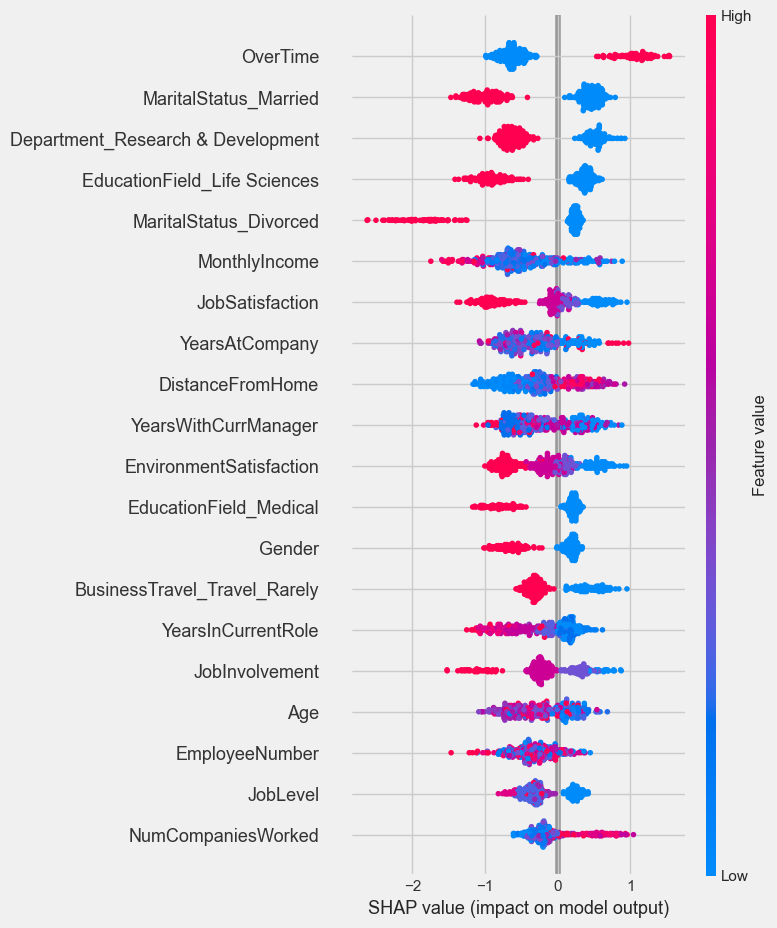

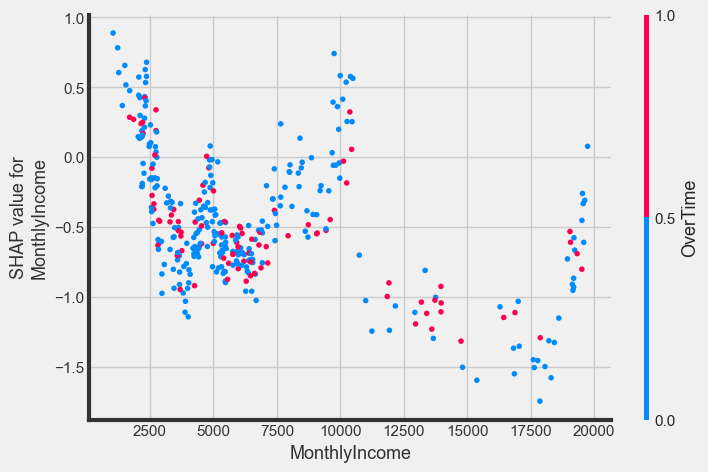

In [134]:
# Erstellung SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)

# Dependence plot für das Merkmal "Monthly Income"
shap.dependence_plot('MonthlyIncome', shap_values, X_test)